In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
torch.set_num_threads(12)

## Load datasets

In [3]:
pil_to_tensor_transform = transforms.ToTensor()
normalizer = transforms.Normalize((0.1307,), (0.3081,))

compose = transforms.Compose([
    pil_to_tensor_transform,
    normalizer,
])

In [4]:
# Train set
train_set = datasets.MNIST('./datasets', train=True, download=True, transform=compose)
# Test set
test_set = datasets.MNIST('./datasets', train=False, download=True, transform=compose)

print(train_set)
print()
print(test_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./datasets
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


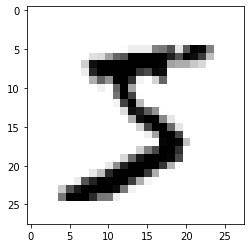

In [5]:
def imshow(tensor):
    plt.imshow(tensor.squeeze(), cmap='binary')
    plt.show()
    
imshow(train_set[0][0])

### Datasets loaders

In [6]:
# PARAMS
BATCH_SIZE = 128
TEST_BATCH_SIZE = 256

In [7]:
# Train set loader
train_set_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
# Test set loader
test_set_loader = data.DataLoader(test_set, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=4)

## Squashing functions

In [8]:
def squash(v):
    dot_prod = v.T @ v
    
    if dot_prod == 0:
        return torch.zeros_like(v)
    
    unit_v = v / torch.sqrt(dot_prod)
    squashing = dot_prod / (dot_prod+1)
    
    return squashing * unit_v

def squash_relu(v, eps=0.00):
    norm = v.norm()
    
    if norm == 0:
        return torch.zeros_like(v)
    
    unit_v = v / norm
    v = torch.tensor([
        a if a > 0 else eps*a for a in v
    ])
    squashing = v.norm()
    
    return squashing * unit_v

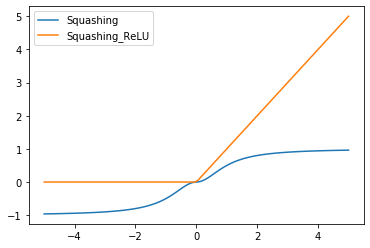

In [9]:
x = torch.linspace(-5, 5)

y = [squash(torch.tensor([v]))[0] for v in x]
y_relu = [squash_relu(torch.tensor([v]))[0] for v in x]

plt.plot(x, y);
plt.plot(x, y_relu);

plt.legend(['Squashing', 'Squashing_ReLU']);

## Convolutional Layer

In [10]:
class ConvLayer(nn.Module):
    '''A Convolutional Layer'''
    
    def __init__(self, in_channels=1, out_channels=256, kernel_size=9):
        super(ConvLayer, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size)
        
    def forward(self, x):
        return F.relu(self.conv(x))

## Primary Capsules

In [11]:
class PrimaryCaps(nn.Module):
    '''Primary Capsules'''
    
    def __init__(self, num_capsules=32, in_channels=256, out_channels=8, kernel_size=9, stride=2):
        super(PrimaryCaps, self).__init__()
        
        self.out_channels = out_channels
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size, stride) for _ in range(num_capsules)
        ])
    
    def forward(self, x):
        output = []
        
        for capsule in self.capsules:
            out = F.relu(capsule(x))
            output.append(out)
        
        output = torch.stack(output, dim=1)
        output = output.view(x.size(0), -1, self.out_channels)
        
        return self.activation(output)
    
    def activation(self, x):
        '''Squash'''
        
        squared_norm = (x**2).sum(-1, keepdim=True) + 1e-18
        squashing_coef = squared_norm / (1 + squared_norm)
        
        unit = x / torch.sqrt(squared_norm)
        
        return squashing_coef * unit

## Digit Capsules

In [12]:
class DigitCaps(nn.Module):
    '''Digit Capsules'''
    
    def __init__(self, num_capsules=10, num_inputs_per_capsule=32*6*6, in_dim=8, out_dim=16, r=3, cuda=False):
        super(DigitCaps, self).__init__()
        
        self.num_capsules = num_capsules
        self.num_inputs_per_capsule = num_inputs_per_capsule
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.r = r
        self.cuda = cuda
        
        self.W = nn.Parameter(
            torch.randn(num_inputs_per_capsule, num_capsules, out_dim, in_dim, dtype=torch.float32)
        )
    
    def routing(self, u_hat):
        '''Dynamic Routing (Routing By Agreement)'''
        
        b_ij = torch.zeros(self.num_inputs_per_capsule, self.num_capsules, dtype=torch.float32)

        if self.cuda and torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        b_ij = b_ij.to(device)
        
        for iteration in range(self.r):
            c_ij = F.softmax(b_ij, dim=0)
            c_ij = torch.stack([c_ij] * u_hat.size(0), dim=0).unsqueeze(3).unsqueeze(4)
            
            s_j = (u_hat @ c_ij).sum(dim=1)
            v_j = self.activation(s_j)
            
            if iteration < self.r - 1:
                d = u_hat.transpose(3, 4) @ torch.stack([v_j] * self.num_inputs_per_capsule, dim=1)
                b_ij = b_ij + d.squeeze(4).squeeze(3).mean(dim=0)
            
        return v_j.squeeze(3)
        
    def forward(self, x):
        
        # Get the dimensions right
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)
        W = torch.stack([self.W] * x.size(0), dim=0)
        
        # Affine Transformation
        u_hat = W @ x
        
        # Dynamic Routing
        return self.routing(u_hat)
        
    def activation(self, x):
        '''Squash'''
        
        squared_norm = (x**2).sum(-1, keepdim=True) + 1e-18
        squashing_coef = squared_norm / (1 + squared_norm)
        
        unit = x / torch.sqrt(squared_norm)
        
        return squashing_coef * unit

In [13]:
output = DigitCaps()(PrimaryCaps()(ConvLayer()(torch.randn(64, 1, 28, 28))))

In [14]:
output.size()

torch.Size([64, 10, 16])

## Decoder

In [15]:
class Decoder(nn.Module):
    '''Capsule Net Decoder'''
    
    def __init__(self, in_dim=16, out_dim=28*28):
        super(Decoder, self).__init__()
        
        self.reconstruction_layers = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, out_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        most_active_idx = torch.norm(x, dim=2).argmax(dim=1)
        x_masked = torch.stack([x[i, idx] for i, idx in zip(range(x.size(0)), most_active_idx)], dim=0)
        
        return self.reconstruction_layers(x_masked)

# Capsule Network

In [16]:
class CapsNet(nn.Module):
    '''Capsule Network'''
    
    def __init__(self, cuda=False):
        super(CapsNet, self).__init__()
        
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps(cuda=cuda)
        self.decoder = Decoder()
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = self.primary_capsules(x)
        x = self.digit_capsules(x)
        
        reconstruction = self.decoder(x)
        
        return x, reconstruction
    
    @staticmethod
    def loss(output, targets, reconstruction, images):
        return CapsNet.margin_loss(output, targets) + \
            CapsNet.reconstruction_loss(reconstruction, images)

    @staticmethod
    def margin_loss(output, targets, lmbd=0.5, m_plus=0.9, m_minus=0.1):
        probs = torch.norm(output, dim=2)
        left = F.relu(m_plus - probs)**2
        right = F.relu(probs - m_minus)**2

        most_active_idx = probs.argmax(dim=1)
        T = (most_active_idx == targets).float().unsqueeze(1)
        loss = T * left + lmbd*(1 - T) * right
        
        return loss.sum()
    
    @staticmethod
    def reconstruction_loss(reconstruction, images, criterion=nn.MSELoss()):
        return criterion(reconstruction, images.view(reconstruction.size(0), -1))

# Train

In [19]:
USE_CUDA = True
EPOCHS = 30

if USE_CUDA and torch.cuda.is_available():
    print('USING CUDA')
    device = torch.device('cuda')
else:
    print('USING CPU')
    device = torch.device('cpu')

capsnet = CapsNet(cuda=USE_CUDA)
capsnet = capsnet.to(device)
optimizer = optim.SGD(capsnet.parameters(), lr=1e-5)


USING CPU


In [20]:
for epoch in range(1, EPOCHS+1):
    
    print()
    print('='*10, 'TRAIN', '='*10)
    capsnet.train()
    running_loss = 0.0
    running_accuracy = 0.0
    
    for i, batch in enumerate(train_set_loader, 1):
        optimizer.zero_grad()
        
        # Load the batch
        images, targets = batch
        images = images.to(device)
        targets = targets.to(device)
        
        # Forward
        output, reconstruction = capsnet(images)
        # Compute loss
        loss = CapsNet.loss(output, targets, reconstruction, images)
        # Compute accuracy
        most_active_idx = output.norm(dim=2).argmax(dim=1)
        accuracy = torch.sum((most_active_idx == targets)).item() / targets.size(0)
        # Backward
        loss.backward()
        # Optim step
        optimizer.step()
        
        # Add loss
        running_loss += loss.item()
        # Add accuracy
        running_accuracy += accuracy
        
        if i % 100 == 0:
            print(f'==> EPOCH[{epoch}] ({i}/{len(train_set_loader)}): LOSS: {loss.item()} ACCURACY: {accuracy}')
            
    print(f'=====> EPOCH[{epoch}] Completed: \
        Avg. LOSS: {running_loss/len(train_set_loader)} Avg. ACCURACY {running_accuracy/len(train_set_loader)}')
    
    print()
    print('='*10, 'EVAL', '='*10)
    capsnet.eval()
    running_accuracy = 0.0
    
    for i, batch in enumerate(test_set_loader, 1):

        # Load the batch
        images, targets = batch
        images = images.to(device)
        targets = targets.to(device)
        
        with torch.no_grad():
            # Forward
            output, reconstruction = capsnet(images)
            most_active_idx = output.norm(dim=2).argmax(dim=1)
            running_accuracy += torch.sum((most_active_idx == targets)).item() / targets.size(0)

    print(f'=====> EPOCH[{epoch}]: AVG. ACCURACY: {running_accuracy/len(test_set_loader)}')


========== TRAIN ==========
==> EPOCH[1] (1/469): LOSS: 57.88624572753906 ACCURACY: 0.0546875
==> EPOCH[1] (2/469): LOSS: 90.25154113769531 ACCURACY: 0.0859375
==> EPOCH[1] (3/469): LOSS: 82.15869140625 ACCURACY: 0.078125
==> EPOCH[1] (4/469): LOSS: 114.5154800415039 ACCURACY: 0.109375
==> EPOCH[1] (5/469): LOSS: 57.89715576171875 ACCURACY: 0.0546875
==> EPOCH[1] (6/469): LOSS: 65.95892333984375 ACCURACY: 0.0625
==> EPOCH[1] (7/469): LOSS: 41.70224380493164 ACCURACY: 0.0390625


KeyboardInterrupt: 